# SET UP

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import umap
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats import multitest
import matplotlib.colors as mcolors
from scipy.stats import hypergeom

In [2]:
ct_to_col = {
    'CD4 T': '#1f77b4',
    'CD14 Monocytes': '#ff7f0e',
    'B': '#279e68',
    'CD8 T': '#d62728',
    'FCGR3A Monocytes': '#aa40fc',
    'NK': '#8c564b',
    'Dendritic': '#e377c2',
    'Megakaryocytes': '#b5bd61'
}

In [3]:
def flux_transformer(v):

    def adjusted(v):
        new = (np.log2(v + 0.125) + 3) / 4
        return np.min([new, 1])

    if v == 0:
        vprime = 0
    elif v > 0:
        if v < 2:
            vprime = adjusted(v)
        else:
            vprime = np.log2(v)
    elif v < 0:
        v = np.abs(v)
        if v < 2:
            vprime = -adjusted(v)
        else:
            vprime = -np.log2(v)
    else:
        raise ValueError('found value not considered')

    return vprime

# DATA PREPARATION

## MODELS SIMULATION RESULTS

,biomass_maintenance,objective_value,percent_ov
CTTAAGCTCCGCTT-1,96.848548,22865.793371,8.265247
CATCAGGATTTCGT-1,215.338298,116172.757726,41.992703
ATAAACACAGTGCT-1,120.975824,90882.347309,32.851036
CATTTGACCACACA-1,183.243383,124855.015309,45.131059
CATTTGTGCGGAGA-1,160.656761,117989.963695,42.649565
...,...,...,...
ATATGCCTTCTCTA-1,195.155178,123658.083021,44.698407
CTATACTGAGGTTC-1,181.681237,87139.825046,31.498235
GTTGAGTGGTCTTT-1,193.268494,93911.227706,33.945879
GCGGAGCTCCTGAA-1,107.307576,132906.872636,48.041546


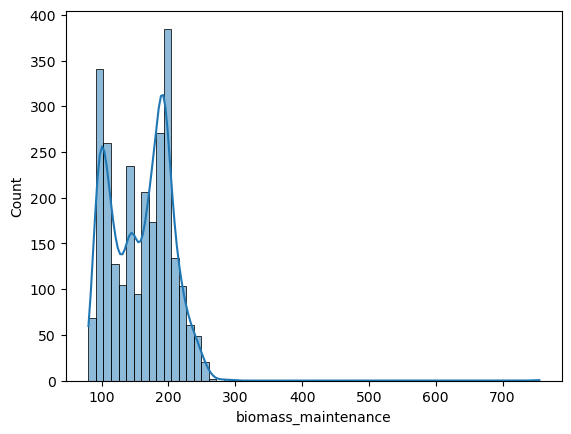

In [4]:
r_models = pd.read_csv("/Users/claudiavicentecomorera/Desktop/TFG/Results/PBMC3k/pfba_rmodels_pbmc3k.csv", index_col = 0)
sns.histplot(r_models, x = "biomass_maintenance", bins = 60, kde = True)
r_models

## FLUXOMES DATAFRAME

In [5]:
fluxes_df = pd.read_csv("/Users/claudiavicentecomorera/Desktop/TFG/Results/PBMC3k/pfba_fluxes_pbmc3k.csv", index_col = 0)
fluxes_df

,2HBO,34DHOXPEGOX,34DHOXPEGt,34DHPHAMT,34DHPLACOX_NADP_,34DHXMANDACOX_NADP_,34HPLFM,3DPHBH1,3HBCDm,3HBCOAHLm,...,DM_btn[m],DCMPtm,PROTEIN_BS,DM_PROTEIN,ATPS4mi,CYOR_u10mi,Htmi,NADH2_u10mi,CYOOm3i,CYOOm2i
CTTAAGCTCCGCTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CATCAGGATTTCGT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATAAACACAGTGCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.393926,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CATTTGACCACACA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,587.485640,-1.463954e-13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CATTTGTGCGGAGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATATGCCTTCTCTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.681376e+02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CTATACTGAGGTTC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GTTGAGTGGTCTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCGGAGCTCCTGAA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4.825089e+02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## FLUXES TRANSFORMATION

This function transforms fluxes into log2 scale with three additions:
- Zero values are kept
- Values between 0 and 2 are adjusted to fit below one
- Negative fluxes are considered

In [6]:
t_fluxes_df = fluxes_df.applymap(flux_transformer)

## REACTIONS FILTERING

### STEPS:
- Order the fluxes of each reaction from smallest to largest
- Keep the central 2/3 (66%) of the fluxes distribution from each reaction
- Calculate the units of difference between the smallest and larger flux value (range)
- Order reactions by its range, from largest to smallest
- Select the top 2000 reactions

In [7]:
f = len(t_fluxes_df)
c = f//2
n = f * 1 // 3

diff_rx = pd.DataFrame(columns = ['Reaction', 'Range'])
for col in t_fluxes_df.columns:
    s_fluxes = t_fluxes_df[col].sort_values()
    c_fluxes = s_fluxes.iloc[c - n : c + n]
    diff_rx = pd.concat([diff_rx, pd.DataFrame({'Reaction': [col], 'Range': [c_fluxes.max() - c_fluxes.min()]})], ignore_index = True)

diff_rx = diff_rx.sort_values(by = 'Range', ascending = False)
ft_fluxes_df = t_fluxes_df[diff_rx.head(2000)['Reaction']]

# RESULTS VISUALIZATION

## COLOR MAPPING

In [8]:
c_labs = pd.read_csv('/Users/claudiavicentecomorera/Desktop/TFG/Data/PBMC/clabs_pbmc.csv')
d_clabs = {}

for index, row in c_labs.iterrows():
    cell = row['Cell_Name']
    type = row['Cluster_Label']

    if type in d_clabs:
        d_clabs[type].append(cell)
    else:
        d_clabs[type] = [cell]

In [9]:
colors = []

for cell in ft_fluxes_df.index:
    for type in d_clabs:
        for cells in d_clabs[type]:
            if cell in cells:
                colors.append(ct_to_col[type]) 
                break  

In [10]:
l = []
l_labs = []

for key, value in d_clabs.items():
    l.append(plt.Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = ct_to_col[key], markersize = 10))
    l_labs.append(key)

## UMAP PROJECTION

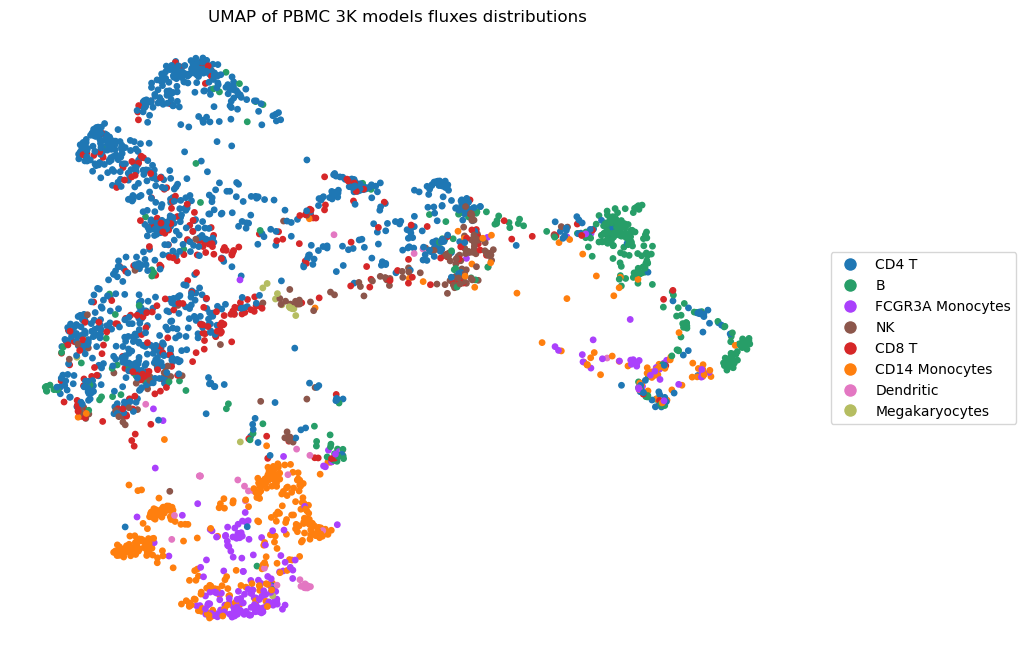

In [11]:
reducer = umap.UMAP(n_neighbors = 25, min_dist = 0.1)   #####
embedding = reducer.fit_transform(ft_fluxes_df)

plt.figure(figsize = (10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c = colors, s = 15) 
plt.legend(l, l_labs, bbox_to_anchor = (1.05, 0.5), loc = 'center left')
plt.title('UMAP of PBMC 3K models fluxes distributions')
plt.axis('off') 
plt.show()

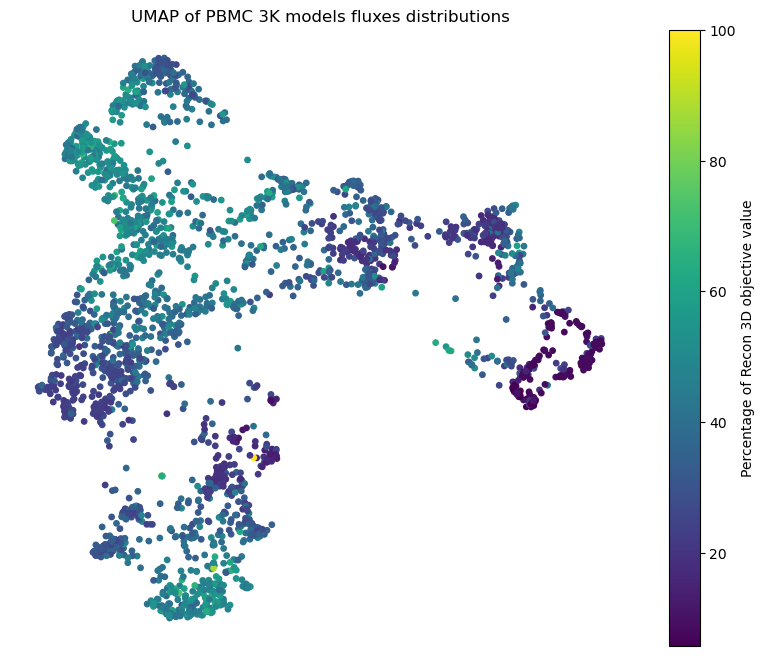

In [12]:
fd_ov = dict(zip(r_models.index, r_models['percent_ov']))

plt.figure(figsize = (10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c = [fd_ov.get(index, -1) for index in ft_fluxes_df.index], cmap = "viridis", s = 15)
plt.colorbar(label = 'Percentage of Recon 3D objective value')  
plt.title('UMAP of PBMC 3K models fluxes distributions')
plt.axis('off') 
plt.show()

# T-TEST

In [13]:
b_cells = ft_fluxes_df.loc[[cell for cell in d_clabs.get("B")]]
cd4t_cells = ft_fluxes_df.loc[[cell for cell in d_clabs.get("CD4 T")]]

In [14]:
t_statistic, p_values = stats.ttest_ind(b_cells, cd4t_cells, axis = 0)
diff = np.mean(b_cells, axis = 0) - np.mean(cd4t_cells, axis = 0)
p_values[np.isnan(p_values)] = 1.0  

reject, q_values = multitest.fdrcorrection(p_values)
q_values = np.clip(q_values, a_min = 10**(-15), a_max = 1)

t_results = pd.DataFrame({
    'p_value': p_values,
    'q_value': q_values,
    'diff': diff
})

t_results['sign'] = 'NO SIGNIFICANCE'
for idx, row in t_results.iterrows():
    if row['q_value'] < 0.05 and row['diff'] > 1:
        t_results.loc[idx, 'sign'] = 'POSITIVE'
    elif row['q_value'] < 0.05 and row['diff'] < -1:
        t_results.loc[idx, 'sign'] = 'NEGATIVE'

ts_results = t_results[t_results['sign'] != 'NO SIGNIFICANCE']
ts_results

,p_value,q_value,diff,sign
LDH_L,4.248360e-45,1.000000e-15,-6.807513,NEGATIVE
EX_3ump[e],3.423494e-24,1.000000e-15,4.188968,POSITIVE
EX_23cump[e],3.423494e-24,1.000000e-15,-4.188968,NEGATIVE
RE1860E,3.423494e-24,1.000000e-15,4.188968,POSITIVE
RPI,2.714220e-11,2.755553e-10,-2.873963,NEGATIVE
...,...,...,...,...
LHCYSTIN,8.124571e-19,1.000000e-15,-1.580639,NEGATIVE
3HBCOAHLm,2.155279e-20,1.000000e-15,-1.997827,NEGATIVE
ECOAH12m,2.155279e-20,1.000000e-15,-1.997827,NEGATIVE
OIVD2m,2.155279e-20,1.000000e-15,-1.997827,NEGATIVE


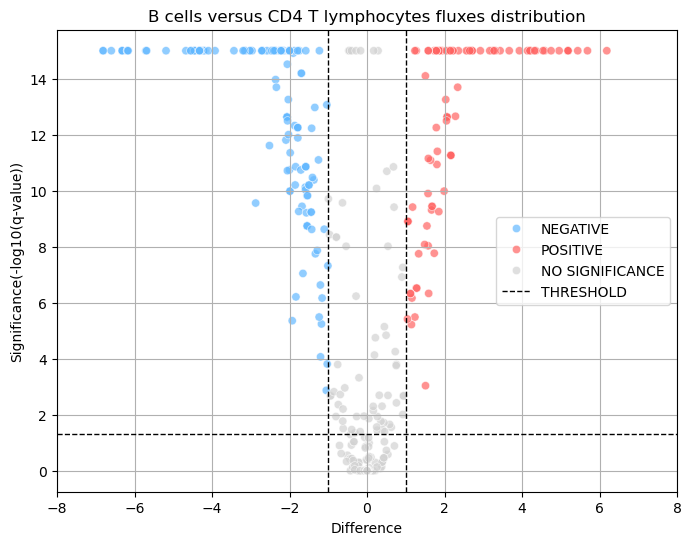

In [15]:
t_colors = {"NO SIGNIFICANCE":"#D2D2D2", "POSITIVE":"#FF6462", "NEGATIVE":"#62B8FF"}

plt.figure(figsize = (8, 6))
sns.scatterplot(x = t_results['diff'], y = -np.log10(t_results['q_value']), hue = t_results['sign'], palette = t_colors, alpha = 0.7)
plt.title('B cells versus CD4 T lymphocytes fluxes distribution')
plt.ylabel('Significance(-log10(q-value))')
plt.xlabel('Difference')
plt.axhline(-np.log10(0.05), color = 'k', linestyle = '--', linewidth = 1, label = 'THRESHOLD')
plt.axvline(1, color = 'k', linestyle = '--', linewidth = 1)
plt.axvline(-1, color = 'k', linestyle = '--', linewidth = 1)
plt.legend(loc = 'best')
plt.xlim(-8, 8)
plt.grid(True)
plt.show()

# HYPERGEOMETRIC TEST

In [16]:
subsystems_df = pd.read_csv('/Users/claudiavicentecomorera/Desktop/TFG/Data/Recon3D_301/recon3D_subsystems.csv')
ts_subsystems = subsystems_df[subsystems_df['ID'].isin(ts_results.index)]

In [17]:
ss_counts = subsystems_df['Subsystem'].value_counts()
m_counts = ts_subsystems['Subsystem'].value_counts()

rx = len(subsystems_df)  
rx_m = len(ts_subsystems)

results = []
for subsystem in ts_subsystems['Subsystem'].unique():
    ss_successes = ss_counts.get(subsystem, 0)
    m_successes = m_counts.get(subsystem, 0)
    p_value = hypergeom.sf(m_successes - 1, rx, ss_successes, rx_m)

    results.append({
        'subsystem': subsystem,
        'count': m_successes,
        'ratio': m_successes/ss_successes,
        'p-value': p_value
    })
ht_results = pd.DataFrame(results)
reject, q_values = multitest.fdrcorrection(ht_results['p-value'])
ht_results['q-value'] = q_values


hts_results = ht_results[ht_results['q-value'] < 0.05]
hts_results = hts_results.sort_values(by = 'ratio', ascending = False)
hts_results

,subsystem,count,ratio,p-value,q-value
11,ROS detoxification,3,0.428571,3.308864e-04,1.530349e-03
4,Citric acid cycle,8,0.400000,4.379365e-09,8.101825e-08
1,Pentose phosphate pathway,15,0.365854,2.711770e-15,1.003355e-13
20,Glutathione metabolism,4,0.250000,3.200749e-04,1.530349e-03
24,Glycolysis/gluconeogenesis,9,0.214286,2.180038e-07,2.688714e-06
0,"Valine, leucine, and isoleucine metabolism",8,0.177778,4.691590e-06,4.339721e-05
14,Pyrimidine catabolism,6,0.176471,7.903755e-05,4.873982e-04
26,Arginine and proline metabolism,5,0.125000,1.631037e-03,6.705376e-03
13,Methionine and cysteine metabolism,5,0.108696,3.058425e-03,1.028743e-02
12,Miscellaneous,13,0.085526,2.564939e-05,1.898055e-04


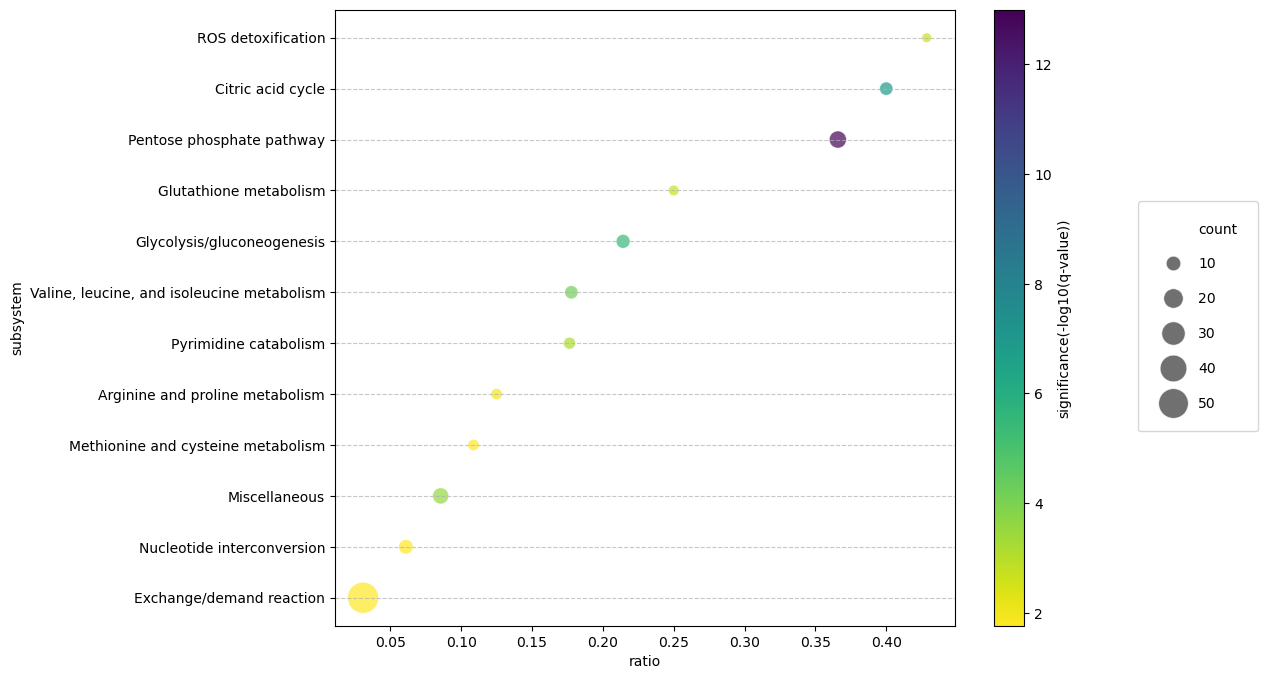

In [18]:
plt.figure(figsize = (10, 8))
sns.scatterplot(data = hts_results, x = 'ratio', y = 'subsystem', size = 'count', sizes = (50, 500), alpha = 0.7,
                hue = -np.log10(hts_results['q-value']), palette = 'viridis_r')

norm = plt.Normalize(vmin = -np.log10(hts_results['q-value']).min(), vmax = -np.log10(hts_results['q-value']).max())
sm = plt.cm.ScalarMappable(cmap = 'viridis_r', norm = norm)
sm.set_array([])
plt.colorbar(sm, ax = plt.gca(), label = 'significance(-log10(q-value))')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend_.remove()
ax.legend(handles[7:], labels[7:], bbox_to_anchor = (1.5, 0.7), labelspacing = 1.5, borderpad = 1.5)

plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.show()

############################################################################################################################

In [19]:
f_array = t_fluxes_df.values.flatten()

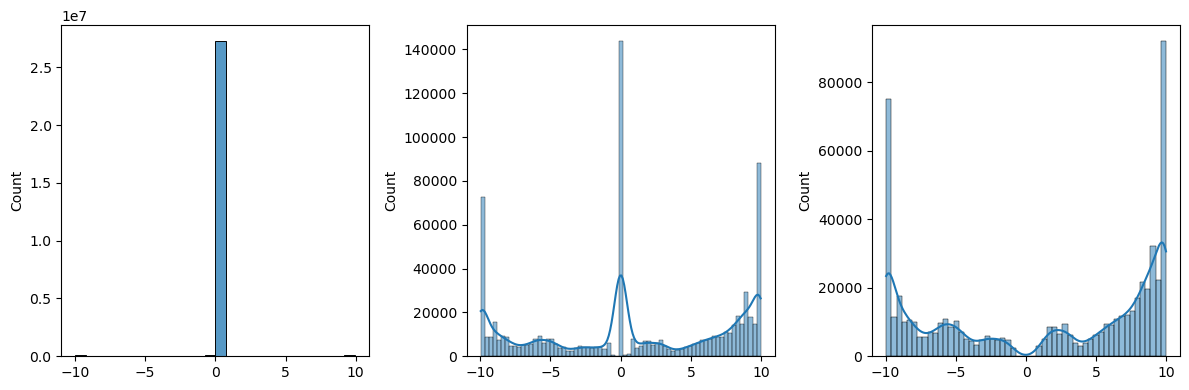

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.histplot(f_array, ax = axes[0], legend = False)
sns.histplot(f_array[f_array != 0], ax = axes[1], legend = False, kde = True)
sns.histplot(f_array[~((f_array > -1) & (f_array < 1))], ax = axes[2], legend = False, kde = True)

plt.tight_layout()
plt.show()